# 1. Data Preparation & Initial Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# LOADING THE DATASETS
train_data = pd.read_csv('medical_train.csv')
test_data = pd.read_csv('medical_test.csv')

# DISPLAYING BASIC INFORMATION
print("Training Data Info:")
print(train_data.info())
print("Test Data Info:")
print(test_data.info())
print("First few rows of the training data:")
print(train_data.head())

# BASIC TEXT PREPROCESSING
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_data['cleaned_text'] = train_data['Conversation'].apply(clean_text)
test_data['cleaned_text'] = test_data['Conversation'].apply(clean_text)

# DISPLAYING CLEANED TEXT
print("First few rows of the cleaned training data:")
print(train_data[['Conversation', 'cleaned_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayaankhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106556 entries, 0 to 106555
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Conversation  106556 non-null  object
dtypes: object(1)
memory usage: 832.6+ KB
None
Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5609 entries, 0 to 5608
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Conversation  5609 non-null   object
dtypes: object(1)
memory usage: 43.9+ KB
None
First few rows of the training data:
                                        Conversation
0  The conversation between human and AI assistan...
1  The conversation between human and AI assistan...
2  The conversation between human and AI assistan...
3  The conversation between human and AI assistan...
4  The conversation between human and AI assistan...
First few rows of the cleaned training data:


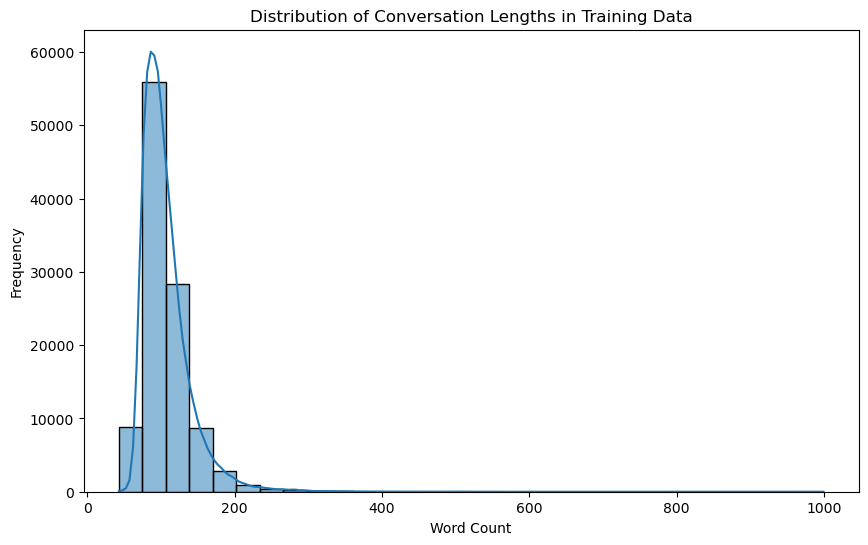

Top 10 most frequent words:
human: 213703
ai: 213128
doctor: 141355
conversation: 106677
assistant: 106631
pain: 95759
chat: 90761
like: 72066
take: 69778
also: 68363


In [2]:
# EXPLORATORY DATA ANALYSIS (EDA)

# PLOTTING DISTRIBUTION OF CONVERSATION LENGTHS
train_data['word_count'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, bins=30)
plt.title('Distribution of Conversation Lengths in Training Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# WORD FREQUENCY ANALYSIS
vectorizer = CountVectorizer()
train_vectors = vectorizer.fit_transform(train_data['cleaned_text'])
sum_words = train_vectors.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
top_words = words_freq[:10]  # Top 10 words
print("Top 10 most frequent words:")
for word, freq in top_words:
    print(f'{word}: {freq}')

# 2. Baseline Model Development & Evaluation

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# DEFINING SIMPLE FUNCTION TO CATEGORIZE URGENCY
def categorize_urgency(text):
    low_urgency_keywords = ['checkup', 'routine', 'follow-up']
    high_urgency_keywords = ['emergency', 'urgent', 'critical', 'severe']
    if any(keyword in text for keyword in high_urgency_keywords):
        return 'High'
    elif any(keyword in text for keyword in low_urgency_keywords):
        return 'Low'
    else:
        return 'Medium'
    
# APPLYING FUNCTION TO CREATE 'URGENCY' C0LUMN
train_data['Urgency'] = train_data['cleaned_text'].apply(categorize_urgency)
test_data['Urgency'] = test_data['cleaned_text'].apply(categorize_urgency)

# VECTORIZATION USING TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

# SPLITTING TRAINING DATA FOR VALIDATION
y = train_data['Urgency']
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y, test_size=0.2, random_state=42)

# BASELINE MODEL TRAINING VIA NAIVE BAYES
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# PREDICTING VALIDATION SET
y_pred = nb_classifier.predict(X_val)

# MODEL EVALUATION
print("Model Evaluation Metrics:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Accuracy Score:", accuracy_score(y_val, y_pred))

# APPLYING MODEL TO TEST DATASET
y_test_pred = nb_classifier.predict(X_test_tfidf)
print("Test Dataset Evaluation:")
print(classification_report(test_data['Urgency'], y_test_pred))

Model Evaluation Metrics:
              precision    recall  f1-score   support

        High       1.00      0.11      0.20      2657
         Low       0.88      0.16      0.27       882
      Medium       0.85      1.00      0.92     17773

    accuracy                           0.85     21312
   macro avg       0.91      0.42      0.46     21312
weighted avg       0.87      0.85      0.80     21312

Confusion Matrix:
[[  292    20  2345]
 [    1   143   738]
 [    0     0 17773]]
Accuracy Score: 0.8543543543543544
Test Dataset Evaluation:
              precision    recall  f1-score   support

        High       1.00      0.11      0.21       696
         Low       0.72      0.12      0.20       226
      Medium       0.85      1.00      0.92      4687

    accuracy                           0.85      5609
   macro avg       0.86      0.41      0.44      5609
weighted avg       0.87      0.85      0.80      5609



# 3. Advanced Model Development

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# MODEL 1: SUPPORT VECTOR MACHINE (SVM)

tfidf_vectorizer = TfidfVectorizer(max_features=2000, min_df=0.01)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

y = train_data['Urgency']
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y, test_size=0.2, random_state=42)

# CONFIGURING SGDCLASSIFIER TO PERFORM AS A LINEAR SVM
sgd_svm = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, max_iter=1000, tol=1e-3, random_state=42)

sgd_svm.fit(X_train, y_train)
y_pred = sgd_svm.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Accuracy Score:", accuracy_score(y_val, y_pred))

y_test_pred = sgd_svm.predict(X_test_tfidf)
print("Test Dataset Evaluation:")
print(classification_report(test_data['Urgency'], y_test_pred))

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.18      0.31      2657
         Low       0.62      0.01      0.01       882
      Medium       0.85      1.00      0.92     17773

    accuracy                           0.86     21312
   macro avg       0.83      0.40      0.41     21312
weighted avg       0.86      0.86      0.81     21312

Accuracy Score: 0.8567942942942943
Test Dataset Evaluation:
              precision    recall  f1-score   support

        High       1.00      0.18      0.30       696
         Low       1.00      0.00      0.01       226
      Medium       0.85      1.00      0.92      4687

    accuracy                           0.86      5609
   macro avg       0.95      0.39      0.41      5609
weighted avg       0.88      0.86      0.81      5609



In [5]:
# MODEL 2: LOGISTIC REGRESSION

# CONTINUING USING THE OPTIMIZED FEATURE SETTINGS
tfidf_vectorizer = TfidfVectorizer(max_features=2000, min_df=0.01)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

# SPLITTING TRAINING DATA FOR VALIDATION PURPOSES
y = train_data['Urgency']
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y, test_size=0.2, random_state=42)

# CONFIGURING SGDCLASSIFIER TO PERFORM AS LOGISTIC REGRESSION
sgd_logistic = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, max_iter=1000, tol=1e-3, random_state=42)

sgd_logistic.fit(X_train, y_train)
y_pred = sgd_logistic.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Accuracy Score:", accuracy_score(y_val, y_pred))

y_test_pred = sgd_logistic.predict(X_test_tfidf)
print("Test Dataset Evaluation:")
print(classification_report(test_data['Urgency'], y_test_pred))

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.02      0.04      2657
         Low       0.00      0.00      0.00       882
      Medium       0.84      1.00      0.91     17773

    accuracy                           0.84     21312
   macro avg       0.61      0.34      0.32     21312
weighted avg       0.82      0.84      0.76     21312

Accuracy Score: 0.8366647897897898
Test Dataset Evaluation:
              precision    recall  f1-score   support

        High       1.00      0.03      0.06       696
         Low       0.00      0.00      0.00       226
      Medium       0.84      1.00      0.91      4687

    accuracy                           0.84      5609
   macro avg       0.61      0.34      0.33      5609
weighted avg       0.83      0.84      0.77      5609



/Users/ayaankhan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayaankhan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayaankhan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayaankhan

# 4. Model Optimization & Evaluation

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000, min_df=0.01)
X_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
y = train_data['Urgency']
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# TRANSFORMING TEST DATA USING SAME VECTORIZATION
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])
y_test = test_data['Urgency']

# MANUALLY SELECTING PARAMETERS TO TEST
alphas = [0.0001, 0.001]
losses = ['log_loss', 'hinge']
best_score = 0
best_params = {}

for alpha in alphas:
    for loss in losses:
        sgd = SGDClassifier(loss=loss, alpha=alpha, max_iter=1000, tol=1e-3, penalty='l2', random_state=42)
        sgd.fit(X_train, y_train)
        y_pred = sgd.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        
        if score > best_score:
            best_score = score
            best_params = {'loss': loss, 'alpha': alpha}
            
print("Best parameters:", best_params)
print("Best validation score: {:.2f}".format(best_score))

# TRAINING FINAL MODEL WITH BEST PARAMETERS
final_sgd = SGDClassifier(loss=best_params['loss'], alpha=best_params['alpha'], max_iter=1000, tol=1e-3, penalty='l2', random_state=42)
final_sgd.fit(X_train, y_train)
y_val_pred = final_sgd.predict(X_val)
y_test_pred = final_sgd.predict(X_test_tfidf)

Best parameters: {'loss': 'hinge', 'alpha': 0.0001}
Best validation score: 0.97


In [7]:
# FINAL EVALUATION
print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred))
print("Accuracy Score on Validation Set:", accuracy_score(y_val, y_val_pred))

print("Test Dataset Evaluation:")
print(classification_report(y_test, y_test_pred))

Validation Set Evaluation:
              precision    recall  f1-score   support

        High       1.00      0.87      0.93      2657
         Low       0.98      0.77      0.86       882
      Medium       0.97      1.00      0.99     17773

    accuracy                           0.97     21312
   macro avg       0.98      0.88      0.93     21312
weighted avg       0.97      0.97      0.97     21312

Accuracy Score on Validation Set: 0.9742398648648649
Test Dataset Evaluation:
              precision    recall  f1-score   support

        High       1.00      0.87      0.93       696
         Low       0.96      0.68      0.80       226
      Medium       0.97      1.00      0.98      4687

    accuracy                           0.97      5609
   macro avg       0.97      0.85      0.90      5609
weighted avg       0.97      0.97      0.97      5609



# 5. System Integration & Prototype Testing

In [8]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

model_pipeline = make_pipeline(tfidf_vectorizer, final_sgd)

def predict_urgency(user_input):
    """Predict the urgency of the user input using the trained model pipeline."""
    predicted_urgency = model_pipeline.predict([user_input])[0]
    return predicted_urgency

# PROTOTYPE TESTING WITH EXAMPLE INPUTS
test_inputs = [
    "I have a severe headache and feel dizzy.",
    "Just looking for a routine check-up appointment.",
    "My child has a fever and is very lethargic."
]

for input_text in test_inputs:
    print(f"Input: {input_text}\nPredicted Urgency: {predict_urgency(input_text)}\n")

Input: I have a severe headache and feel dizzy.
Predicted Urgency: High

Input: Just looking for a routine check-up appointment.
Predicted Urgency: Low

Input: My child has a fever and is very lethargic.
Predicted Urgency: Medium



In [9]:
# ENHANCING WITH INTERACTIVE TESTING & ERROR HANDLING

def interactive_urgency_prediction():
    print("Welcome to the Automated Urgency Prediction System")
    print("Please describe your symptoms or enter 'exit' to quit.")

    while True:
        user_input = input("Enter your symptoms: ")
        if user_input.lower() == 'exit':
            print("Thank you for using the Urgency Prediction System. Goodbye!")
            break

        try:
            predicted_urgency = predict_urgency(user_input)
            print(f"Predicted Urgency: {predicted_urgency}\n")
        except Exception as e:
            print(f"An error occurred: {e}")
            print("Please try again or contact support if the problem persists.\n")

if __name__ == "__main__":
    interactive_urgency_prediction()
    
common_medical_terms = set([
    "fever", "headache", "nausea", "dizziness", "pain", "ache", "injury", "cough",
    "cold", "flu", "infection", "virus", "bacteria", "wound", "burn", "bleeding",
    "allergy", "itch", "rash", "swelling", "sore", "vomiting", "diarrhea", "fatigue",
    "weakness", "tired", "depression", "anxiety", "stress", "insomnia"
])

def is_medically_relevant(input_text):
    """Check if the input text contains medically relevant terms."""
    words = set(input_text.lower().split())
    return bool(common_medical_terms & words)

def interactive_urgency_prediction():
    print("Welcome to the Automated Urgency Prediction System")
    print("Please describe your symptoms or enter 'exit' to quit.")

    while True:
        user_input = input("Enter your symptoms: ")
        if user_input.lower() == 'exit':
            print("Thank you for using the Urgency Prediction System. Goodbye!")
            break

        if not is_medically_relevant(user_input):
            print("Your input did not seem to contain medically relevant terms. Please provide more specific symptoms or consult a healthcare professional.")
            continue
        
        try:
            predicted_urgency = predict_urgency(user_input)
            print(f"Predicted Urgency: {predicted_urgency}\n")
        except Exception as e:
            print(f"An error occurred: {e}")
            print("Please try again or contact support if the problem persists.\n")

if __name__ == "__main__":
    interactive_urgency_prediction()

Welcome to the Automated Urgency Prediction System
Please describe your symptoms or enter 'exit' to quit.
Enter your symptoms: Headache
Predicted Urgency: Medium

Enter your symptoms: Nausea
Predicted Urgency: Medium

Enter your symptoms: exit
Thank you for using the Urgency Prediction System. Goodbye!
Welcome to the Automated Urgency Prediction System
Please describe your symptoms or enter 'exit' to quit.
Enter your symptoms: exit
Thank you for using the Urgency Prediction System. Goodbye!


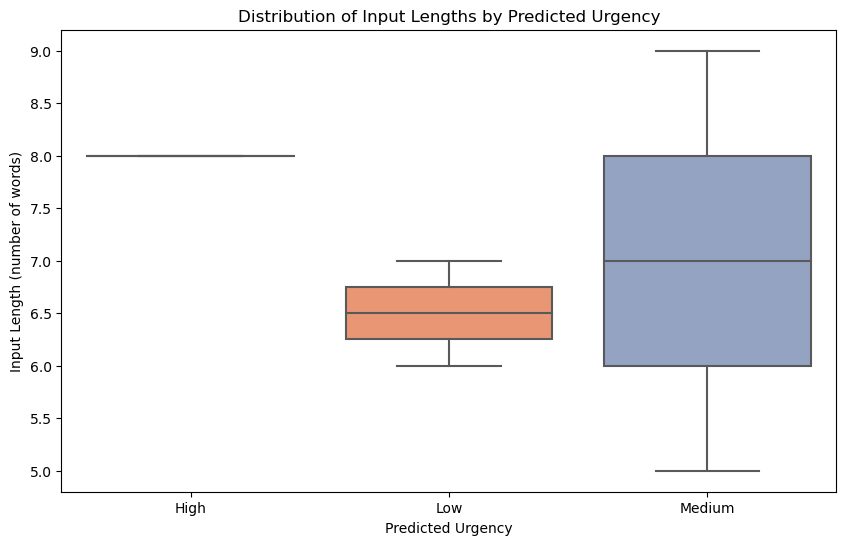

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# USER INPUTS
user_inputs = [
    "I have a severe headache and feel dizzy.",
    "Just looking for a routine check-up appointment.",
    "My child has a fever and is very lethargic.",
    "I have a cough and cold.",
    "Feeling tired all the time"
]
predictions = ['High', 'Low', 'Medium', 'Low', 'Medium']

# CALCULATING THE LENGTH OF EACH INPUT
input_lengths = [len(input.split()) for input in user_inputs]

# COMBINING THE LENGTHS & PREDICTIONS INTO A DATAFRAME
import pandas as pd
data = pd.DataFrame({
    'Input Length': input_lengths,
    'Predicted Urgency': predictions
})

# CREATING A BOXPLOT TO SEE DISTRIBUTION OF INPUT LENGTHS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Predicted Urgency', y='Input Length', data=data, palette='Set2')
plt.title('Distribution of Input Lengths by Predicted Urgency')
plt.xlabel('Predicted Urgency')
plt.ylabel('Input Length (number of words)')
plt.show()